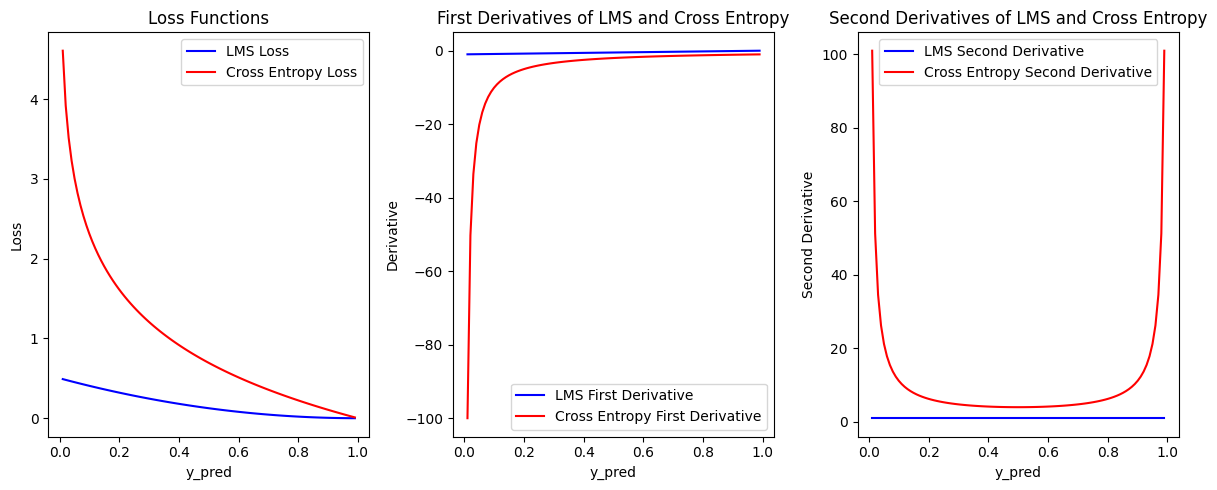

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lms_loss(y_true, y_pred):
    return 0.5 * (y_true - y_pred) ** 2

def cross_entropy_loss(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def lms_loss_derivative(y_true, y_pred):
    return y_pred - y_true

def cross_entropy_derivative(y_true, y_pred):
    return (y_pred - y_true) / (y_pred * (1 - y_pred))

def lms_loss_second_derivative(y_pred):
    return np.ones_like(y_pred)

def cross_entropy_second_derivative(y_pred):
    return (y_pred * (1 - y_pred)) ** -1

# Generate data
y_pred = np.linspace(0.01, 0.99, 100)  # Avoid division by zero

y_true = 1  # Target output

# Compute loss values
lms_values = lms_loss(y_true, y_pred)
cross_entropy_values = cross_entropy_loss(y_true, y_pred)

# Compute first and second derivatives
lms_first_derivative = lms_loss_derivative(y_true, y_pred)
cross_entropy_first_derivative = cross_entropy_derivative(y_true, y_pred)
lms_second_derivative = lms_loss_second_derivative(y_pred)
cross_entropy_second_derivative = cross_entropy_second_derivative(y_pred)

# Plotting loss functions
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(y_pred, lms_values, label='LMS Loss', color='blue')
plt.plot(y_pred, cross_entropy_values, label='Cross Entropy Loss', color='red')
plt.legend()
plt.title('Loss Functions')
plt.xlabel('y_pred')
plt.ylabel('Loss')

# Plotting first derivatives
plt.subplot(1, 3, 2)
plt.plot(y_pred, lms_first_derivative, label='LMS First Derivative', color='blue')
plt.plot(y_pred, cross_entropy_first_derivative, label='Cross Entropy First Derivative', color='red')
plt.legend()
plt.title('First Derivatives of LMS and Cross Entropy')
plt.xlabel('y_pred')
plt.ylabel('Derivative')

# Plotting second derivatives
plt.subplot(1, 3, 3)
plt.plot(y_pred, lms_second_derivative, label='LMS Second Derivative', color='blue')
plt.plot(y_pred, cross_entropy_second_derivative, label='Cross Entropy Second Derivative', color='red')
plt.legend()
plt.title('Second Derivatives of LMS and Cross Entropy')
plt.xlabel('y_pred')
plt.ylabel('Second Derivative')

plt.tight_layout()
plt.show()


Total MIDI files: 0
Total MIDI files: 1276


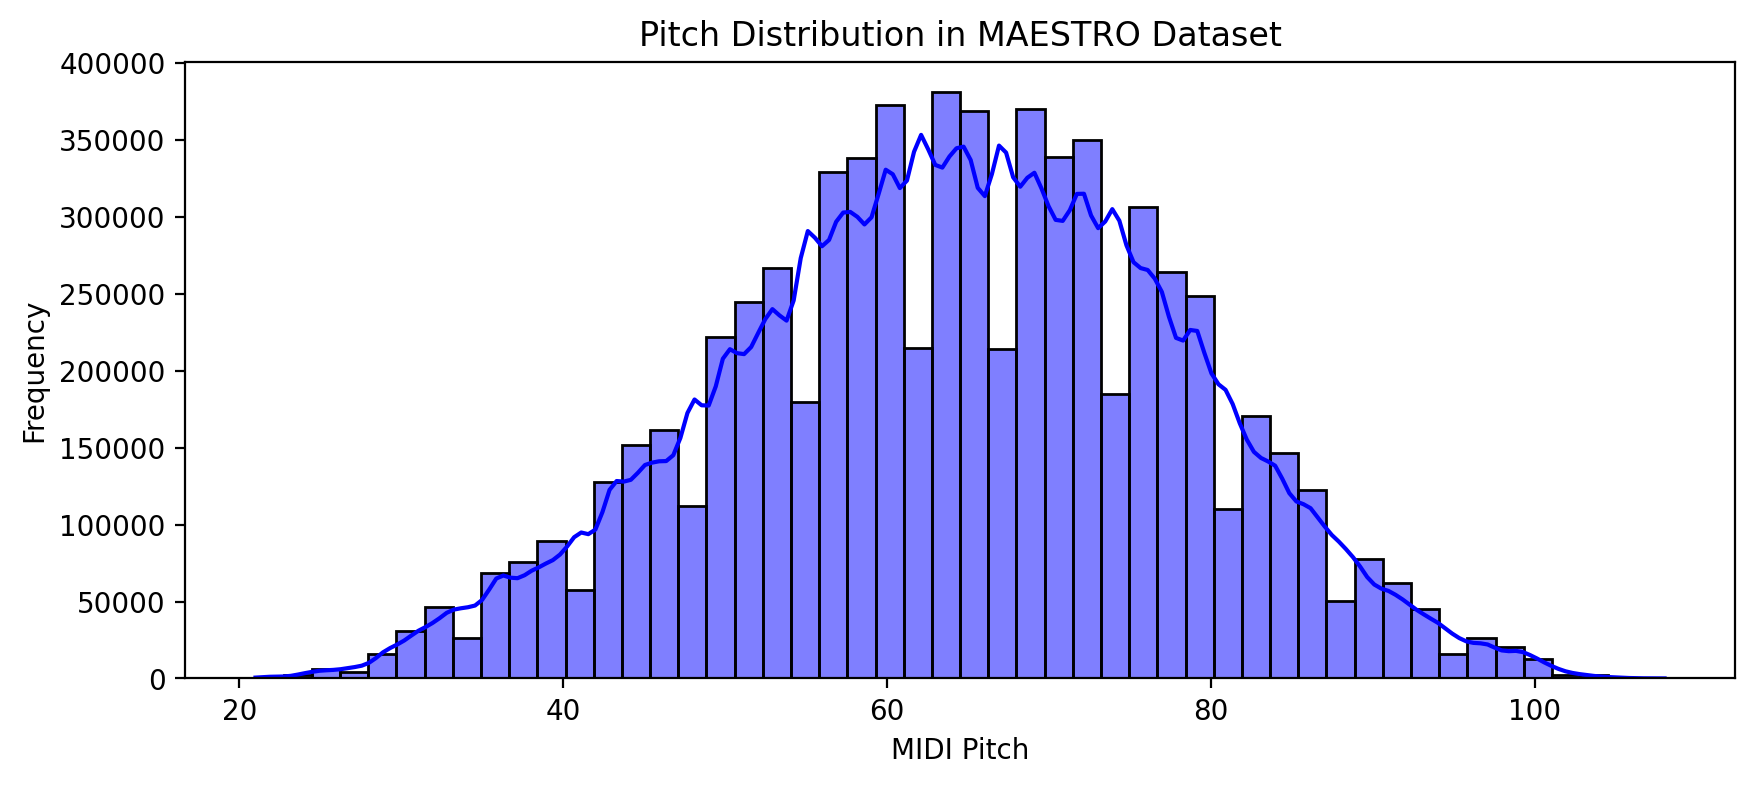

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load MAESTRO Dataset (Example Path)
dataset_path = "/content/drive/MyDrive/maestro-v3.0.0"
midi_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.midi') or f.endswith('.mid')]

# Display number of MIDI files available
print(f"Total MIDI files: {len(midi_files)}")
# Function to find all MIDI files in the directory and its subdirectories
def find_midi_files(dataset_path):
    midi_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.midi') or file.endswith('.mid'):
                midi_files.append(os.path.join(root, file))
    return midi_files

# Load all MIDI files from dataset path and subdirectories
midi_files = find_midi_files(dataset_path)

# Display the number of MIDI files found
print(f"Total MIDI files: {len(midi_files)}")


# Function to extract MIDI note sequences
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            notes.append([note.start, note.end, note.pitch, note.velocity])
    return np.array(notes)

# Process all MIDI files
all_notes = [midi_to_notes(f) for f in midi_files]
all_notes = np.concatenate(all_notes, axis=0)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 4))
sns.histplot(all_notes[:, 2], bins=50, kde=True, color="blue")
plt.xlabel("MIDI Pitch")
plt.ylabel("Frequency")
plt.title("Pitch Distribution in MAESTRO Dataset")
plt.show()

# Convert MIDI to piano roll representation
def midi_to_piano_roll(midi_file, fs=100):
    pm = pretty_midi.PrettyMIDI(midi_file)
    piano_roll = pm.get_piano_roll(fs=fs)
    return piano_roll.T  # Transpose for proper time-step format

piano_rolls = [midi_to_piano_roll(f) for f in midi_files]

# Define maximum sequence length and pad sequences
max_length = 1000
piano_rolls = [x[:max_length] if x.shape[0] > max_length else np.pad(x, ((0, max_length - x.shape[0]), (0, 0))) for x in piano_rolls]

# Convert to NumPy array
X = np.array(piano_rolls)

# Data Splitting (Train, Validation, Test)
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Normalize input data
X_train = X_train / 127.0  # MIDI velocities range from 0-127
X_val = X_val / 127.0
X_test = X_test / 127.0

# Define LSTM-based Music Generation Model
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(max_length, X_train.shape[2])),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(X_train.shape[2], activation='sigmoid')
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, X_train, epochs=50, validation_data=(X_val, X_val), batch_size=16)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate Music Sequence
generated_sequence = model.predict(X_test[:1])  # Generate for one test sample

# Convert generated sequence to MIDI
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    for time, pitch_vector in enumerate(piano_roll):
        for pitch, velocity in enumerate(pitch_vector):
            if velocity > 0:
                note = pretty_midi.Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time / fs,
                    end=(time + 1) / fs
                )
                instrument.notes.append(note)
    pm.instruments.append(instrument)
    return pm

generated_midi = piano_roll_to_midi(generated_sequence[0])
generated_midi.write("generated_music.mid")

# Plot Training Loss and Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()
